In [1]:
import os, shutil, sys, warnings, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from zipfile import ZipFile
from tqdm import trange
from tqdm.notebook import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, accuracy_score

In [2]:
np.random.seed(0)
warnings.filterwarnings("ignore")

In [3]:
CONFIG = {
    "TEST_FOLDER" : "level_1_test/kaggle_level_1/",
    "TRAIN_FOLDER" : "level_1_train/level_1/",
    "IMAGE_SIZE": (16, 16),
    "THRESHOLD": 0.5
}

In [4]:
def read_all(folder_path, key_prefix=""):
    print("Reading:")
    images={}
    files = os.listdir(folder_path)
    for i, filename in tqdm(enumerate(files), total=len(files)):
        file_path = os.path.join(folder_path,filename)
        image_index = key_prefix + filename[:-4]
        image = Image.open(file_path)
        image = image.convert("L")
        images[image_index] = np.array(image.copy()).flatten()
        image.close()
    return images

In [5]:
image = Image.open("level_1_train/level_1/en/c0_13.jpg")
image = image.convert("L")
images = np.array(image.copy()).flatten()
image.close()
print(image)

<PIL.Image.Image image mode=L size=16x16 at 0x204EA32FA50>


In [6]:
images

array([254, 249, 255, 243, 255, 251, 255, 253, 255, 254, 255, 255, 251,
       250, 255, 246, 255, 245, 251, 255, 255, 248, 249, 251, 255, 226,
       255, 255, 246, 255, 231, 255, 255, 255, 240, 247, 255, 255, 254,
       255, 255, 255, 247, 255, 248, 255, 255, 254, 250, 239, 255, 252,
       242, 252, 253, 246, 251, 247, 255, 248, 251, 250, 255, 245, 255,
       241, 236, 255, 255, 255,   6,  20,  27,  14, 243,   0,  38, 243,
       255, 252, 246, 255, 255, 229, 255,   0,   0,   0,   0,   1,   0,
        16,   0, 255, 255, 253, 254, 254, 245, 255,   0,   8,   0,  12,
         0,  13,  16,   0,   8, 242, 249, 255, 252, 252, 255,   0,   3,
         0, 255, 241, 252, 255,   0,   9,   0, 255, 255, 249, 255, 249,
       255,   9,   0,  27, 255, 251, 255, 255,   5,   4,   0, 255, 255,
       250, 255, 244, 234,   2,  11,  11, 236, 255, 255, 254,   0,   3,
        14, 249, 255, 255, 250, 255, 255,   0,   1,   0, 255, 245, 240,
       255,   0,   6,   1, 255, 251, 245, 250, 241, 240,   4,   

In [7]:
languages = ['ta', 'hi', 'en'] # tamil, hindi, english
# read in backgrounds with extra 'bgr_' for identification
images_train = read_all(f'{CONFIG["TRAIN_FOLDER"]}background/', key_prefix='bgr_') # change the path
# read in the images from all three languages with extra prefix for identification
for language in languages:
  images_train.update(read_all(CONFIG["TRAIN_FOLDER"] + language, key_prefix=language+"_" ))
print(len(images_train))

# read in test images
images_test = read_all(CONFIG["TEST_FOLDER"], key_prefix='') # change the path
print(len(images_test))

list(images_test.keys())[:5]

X = []
Y = []

Reading:


  0%|          | 0/447 [00:00<?, ?it/s]

Reading:


  0%|          | 0/146 [00:00<?, ?it/s]

Reading:


  0%|          | 0/149 [00:00<?, ?it/s]

Reading:


  0%|          | 0/150 [00:00<?, ?it/s]

892
Reading:


  0%|          | 0/297 [00:00<?, ?it/s]

297


In [8]:
# add the image to columns then check if it is background image or not, depending on that put 0 or 1 in target
for key, value in images_train.items():
    X.append(value)
    if key[:4] == "bgr_":
        Y.append(0)
    else:
        Y.append(1)

ID_test = []
X_test = []
for key, value in images_test.items():
  ID_test.append(int(key))
  X_test.append(value)
  
        
X = np.array(X)
Y = np.array(Y)
X_test = np.array(X_test)

print(X.shape, Y.shape)
print(X_test.shape)

(892, 256) (892,)
(297, 256)


In [9]:
print(X.shape, Y.shape, X_test.shape)

(892, 256) (892,) (297, 256)


In [10]:
def plot_images(images,labels,columns=5,image_size=None,figsize=(8,8),cmap='gray'):
    fig = plt.figure(figsize=figsize)
    fig.tight_layout(h_pad=3)
    rows=math.ceil(len(images)/columns) # size of image array = numrows * numcolumns
    for image,label,position in zip(images,labels,range(1,len(labels)+1)):
        fig.add_subplot(rows,columns,position)
        if image_size is not None:
            image = image.reshape(image_size)
        plt.imshow(image,cmap=cmap,interpolation='nearest')
        plt.axis('off')
        plt.title(label)
    plt.show()

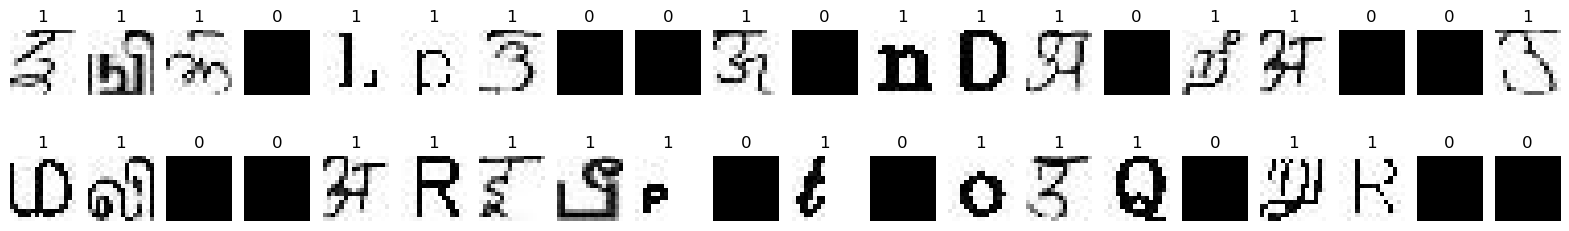

In [11]:
indexs = np.random.randint(1, X.shape[0], size=40) # get few random indexes
plot_images(X[indexs], Y[indexs], image_size=CONFIG["IMAGE_SIZE"], columns=20, figsize=(20, 3))

In [12]:
# splitting for train and validation sets to check bias chances on test data. we already have the test data
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.15, random_state=10, stratify=Y, shuffle=True)

In [13]:
print(X_train.shape, Y_train.shape, X_val.shape, Y_val.shape)
print(Y.mean(), Y_train.mean(), Y_val.mean())

(758, 256) (758,) (134, 256) (134,)
0.49887892376681614 0.49868073878627966 0.5


In [14]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

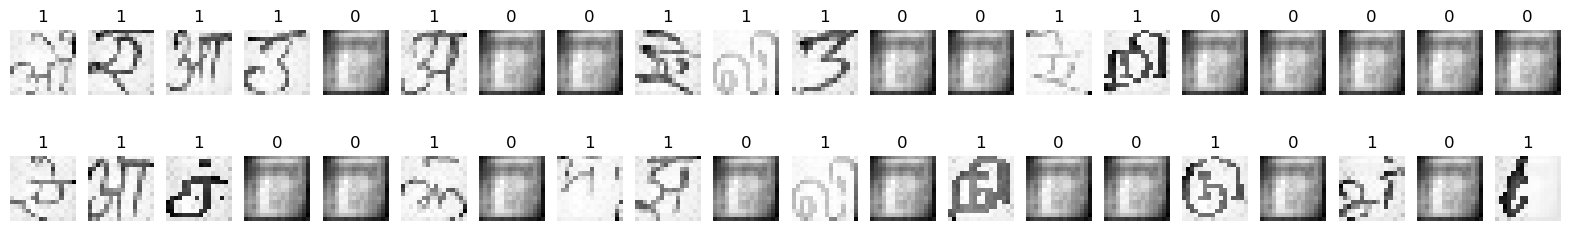

In [15]:
indexs = np.random.randint(1, X_train.shape[0], size=40)
plot_images(X_train[indexs], Y_train[indexs], image_size=CONFIG["IMAGE_SIZE"], columns=20, figsize=(20, 3))

In [17]:
class SigmoidNeuron:
    def __init__(self):
        self.w = None
        self.b = None
        self.train_loss = []
        self.train_accuracy = []
        self.val_loss = []
        self.val_accuracy = []

    def model(self, x):
        return 1. / (1. + np.exp(- (np.dot(self.w, x) + self.b)))

    def predict(self, X):
        return np.asarray([self.model(x) for x in X])

    def loss(self, Y, Y_pred):
        return log_loss(Y, Y_pred)

    def accuracy(self, Y, Y_pred):
        return accuracy_score(Y, (Y_pred >= CONFIG["THRESHOLD"]).astype(int))

    def grad_w(self, x, y, y_pred):
        return (y_pred - y) * x

    def grad_b(self, y, y_pred):
        return y_pred - y

    def fit(self, X_train, Y_train, X_val, Y_val, epochs=1, learning_rate=1, initialise=True):
        if initialise:
            self.w = np.random.randn(1, X_train.shape[1])
            self.b = 0

        for _ in tqdm(range(epochs), total=epochs, unit='epoch', desc='Epoch'):
            Y_pred = self.predict(X_train)

            dw = 0
            db = 0
            for x, y, y_pred in zip(X_train, Y_train, Y_pred):
                dw += self.grad_w(x, y, y_pred)
                db += self.grad_b(y, y_pred)

            self.w -= (learning_rate * dw)
            self.b -= (learning_rate * db)

            Y_pred = self.predict(X_train)
            self.train_loss.append(self.loss(Y_train, Y_pred))
            self.train_accuracy.append(self.accuracy(Y_train, Y_pred))

            Y_val_pred = self.predict(X_val)
            self.val_loss.append(self.loss(Y_val, Y_val_pred))
            self.val_accuracy.append(self.accuracy(Y_val, Y_val_pred))

        print('Final Train Loss:', self.train_loss[-1])
        print('Final Validation Loss:', self.val_loss[-1])
        print('Final Train Accuracy:', self.train_accuracy[-1])
        print('Final Validation Accuracy:', self.val_accuracy[-1])

    def plot_graphs(self):
        plt.plot(self.train_loss, label='Train Loss')
        plt.plot(self.val_loss, label='Test Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Log Loss Error')
        plt.legend()
        plt.show()

        plt.plot(self.train_accuracy, label='Train Accuracy')
        plt.plot(self.val_accuracy, label='Test Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show()

    def evalute(self, X_test, Y_test):
        Y_test_pred = self.predict(X_test)
        print('Test Accuracy:', self.accuracy(Y_test, Y_test_pred))

In [18]:
X_train.shape

(758, 256)

Epoch:   0%|          | 0/150 [00:00<?, ?epoch/s]

Final Train Loss: 4.942875025297785e-05
Final Validation Loss: 0.01813717146383903
Final Train Accuracy: 1.0
Final Validation Accuracy: 0.9925373134328358


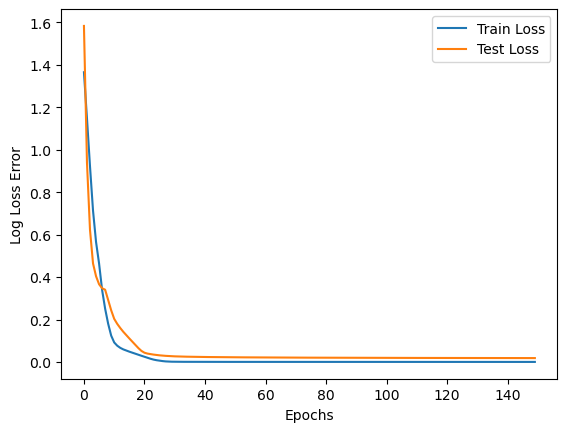

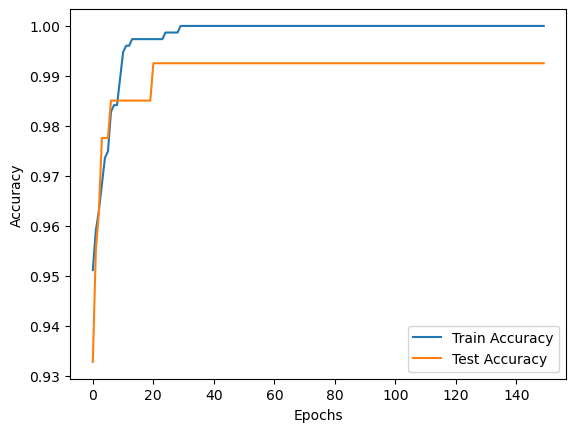

In [19]:
model = SigmoidNeuron()
model.it(X_train, Y_train, X_val, Y_val, epochs=150, learning_rate=0.02)
model.plot_graphs()

In [141]:
my_array = model.predict(X_val)
Y_pred = np.where(my_array >= 0.5, 1, 0)

In [142]:
from sklearn.metrics import confusion_matrix

In [143]:
my_array

array([[1.00000000e+00],
       [1.00000000e+00],
       [1.00000000e+00],
       [6.22283823e-32],
       [1.00000000e+00],
       [9.99999999e-01],
       [1.00000000e+00],
       [1.00000000e+00],
       [6.22283823e-32],
       [9.99999845e-01],
       [6.22283823e-32],
       [6.22283823e-32],
       [6.22283823e-32],
       [6.22283823e-32],
       [1.00000000e+00],
       [1.00000000e+00],
       [1.00000000e+00],
       [1.00000000e+00],
       [6.22283823e-32],
       [6.22283823e-32],
       [6.22283823e-32],
       [1.00000000e+00],
       [1.00000000e+00],
       [6.22283823e-32],
       [1.00000000e+00],
       [6.22283823e-32],
       [6.22283823e-32],
       [6.22283823e-32],
       [6.22283823e-32],
       [6.22283823e-32],
       [1.00000000e+00],
       [1.00000000e+00],
       [1.00000000e+00],
       [1.00000000e+00],
       [1.00000000e+00],
       [1.00000000e+00],
       [6.22283823e-32],
       [1.00000000e+00],
       [1.00000000e+00],
       [6.22283823e-32],


In [144]:
print(confusion_matrix(Y_pred,Y_val))

[[67  1]
 [ 0 66]]
